# Optimization with Genetic Algorithms

## Load TSP problem + display basic info

In [22]:
import tsplib95
import networkx as nx

# load TSP problem 
problem = tsplib95.load_problem('./att48.tsp') 

# display basic info
problem_name = problem.name
num_nodes = problem.dimension
edge_weight_type = problem.edge_weight_type

print("Problem Name:", problem_name)
print("Number of Nodes:", num_nodes)
print("Edge Weight Type:", edge_weight_type)


Problem Name: att48
Number of Nodes: 48
Edge Weight Type: ATT


/var/folders/v4/0f9n6lpx3pn7ghtrplsk92h80000gn/T/ipykernel_2457/1986805321.py:5: DeprecationWarning: Call to deprecated function (or staticmethod) load_problem. (Will be removed in newer versions. Use `tsplib95.load` instead.) -- Deprecated since version 7.0.0.
  problem = tsplib95.load_problem('./att48.tsp')


## Genetic Algorithm Framework

### Chromosome Representation

In [23]:
import random

def create_chromosome(cities):
    """
    Create a chromosome - random permutation of the cities.

    :param cities: is list of cities (or nodes).
    :return: the list representing a random perm of the cities.
    """
    chromosome = cities.copy()
    random.shuffle(chromosome)
    return chromosome

# gets the list of cities from the TSP problem
cities = list(problem.get_nodes())

# creates a chromosome
chromosome = create_chromosome(cities)

print("Chromosome (Tour):", chromosome)


Chromosome (Tour): [4, 40, 19, 14, 18, 2, 32, 22, 11, 12, 17, 15, 21, 27, 37, 44, 28, 48, 3, 39, 16, 30, 29, 24, 6, 9, 45, 20, 10, 5, 7, 35, 33, 13, 34, 26, 31, 43, 1, 8, 42, 46, 36, 41, 25, 47, 23, 38]


### Fitness Function

In [24]:
def calculate_total_distance(chromosome, problem):
    """
    It sums the total distance of the tour represented by the chromosome.

    :param chromosome: is a list representing the tour (perm of cities).
    :param problem: the TSP problem instance from TSPLIB library.
    :return: total distance
    """
    total_distance = 0
    num_cities = len(chromosome)

    for i in range(num_cities):
        # get current city and next city
        current_city = chromosome[i]
        next_city = chromosome[(i + 1) % num_cities]

        # distance between currenct city and next city
        total_distance += problem.get_weight(current_city, next_city)

    return total_distance

# example
chromosome = create_chromosome(cities) # function to create chromosome (from section above)
fitness = calculate_total_distance(chromosome, problem)

print("Total distance of the tour:", fitness)


Total distance of the tour: 45297


## Genetic Operators

### Selection

They are also available with external tools like deep

In [25]:
import random

def roulette_wheel_selection(population, fitnesses):
    """
    Perform roulette wheel selection.

    :param population: A list of chromosomes (individuals).
    :param fitnesses: A list of fitness values corresponding to the chromosomes.
    :return: Selected chromosome.
    """
    total_fitness = sum(fitnesses)
    pick = random.uniform(0, total_fitness)
    current = 0
    for chromosome, fitness in zip(population, fitnesses):
        current += fitness
        if current > pick:
            return chromosome


In [26]:
def tournament_selection(population, fitnesses, tournament_size=3):
    """
    Perform tournament selection.

    :param population: A list of chromosomes (individuals).
    :param fitnesses: A list of fitness values corresponding to the chromosomes.
    :param tournament_size: Number of individuals in each tournament.
    :return: Selected chromosome.
    """
    # random selection of tournament_size indiv
    tournament = random.sample(list(zip(population, fitnesses)), tournament_size)
    
    # besst indiv from the tournament
    best_individual = max(tournament, key=lambda x: x[1])[0]
    return best_individual


### Crossover

In [27]:
def ordered_crossover(parent1, parent2):
    """
    Perform ordered crossover between two parents.

    :param parent1: The first parent chromosome (a tour).
    :param parent2: The second parent chromosome (a tour).
    :return: Two offspring chromosomes.
    """
    size = len(parent1)
    child1, child2 = [-1] * size, [-1] * size

    # select a crossover point range
    start, end = sorted(random.sample(range(size), 2))

    # copy from first parent to first child
    child1[start:end] = parent1[start:end]

    # fill remaining with genes for second parent
    p2_index = 0
    for i in range(size):
        if child1[i] == -1:
            while parent2[p2_index] in child1:
                p2_index += 1
            child1[i] = parent2[p2_index]

    # same process for 2nd child
    child2[start:end] = parent2[start:end]
    p1_index = 0
    for i in range(size):
        if child2[i] == -1:
            while parent1[p1_index] in child2:
                p1_index += 1
            child2[i] = parent1[p1_index]

    return child1, child2


### Mutation

In [28]:
def swap_mutation(chromosome):
    """
    Perform swap mutation on a chromosome.

    :param chromosome: A chromosome (a tour).
    :return: A mutated chromosome.
    """
    idx1, idx2 = random.sample(range(len(chromosome)), 2)
    chromosome[idx1], chromosome[idx2] = chromosome[idx2], chromosome[idx1]
    return chromosome


In [29]:
def scramble_mutation(chromosome):
    """
    Perform scramble mutation on a chromosome.

    :param chromosome: A chromosome (a tour).
    :return: A mutated chromosome.
    """
    start, end = sorted(random.sample(range(len(chromosome)), 2))
    chromosome_to_scramble = chromosome[start:end]
    random.shuffle(chromosome_to_scramble)
    chromosome[start:end] = chromosome_to_scramble
    return chromosome


## Algorithm Initialization

### Population Initialization

In [30]:
def initialize_population(num_individuals, cities):
    """
    Initialize a population for the TSP.

    :param num_individuals: The number of individuals in the population.
    :param cities: A list of cities (nodes).
    :return: A list of chromosomes, where each chromosome is a random tour.
    """
    return [create_chromosome(cities) for _ in range(num_individuals)]

# example
num_individuals = 50  # For example, a population of 50 individuals
population = initialize_population(num_individuals, cities)

# display
print("First few individuals in the population:")
for i in range(min(5, num_individuals)):
    print(population[i])


First few individuals in the population:
[38, 36, 6, 29, 17, 14, 15, 30, 25, 24, 39, 13, 4, 5, 28, 47, 1, 7, 40, 19, 9, 44, 45, 22, 32, 10, 27, 11, 21, 34, 3, 43, 16, 31, 37, 33, 41, 23, 18, 42, 8, 35, 12, 26, 2, 46, 48, 20]
[45, 36, 16, 17, 38, 30, 24, 23, 9, 34, 44, 27, 6, 46, 2, 19, 22, 35, 43, 39, 13, 18, 15, 8, 29, 33, 37, 1, 32, 28, 3, 31, 11, 10, 41, 40, 5, 21, 42, 26, 25, 47, 7, 48, 4, 12, 14, 20]
[11, 24, 29, 28, 47, 16, 10, 35, 15, 23, 41, 13, 46, 39, 43, 4, 8, 9, 44, 20, 34, 48, 37, 45, 40, 31, 36, 38, 17, 7, 1, 32, 30, 19, 5, 3, 21, 33, 14, 12, 22, 25, 26, 2, 18, 6, 27, 42]
[14, 7, 1, 5, 6, 37, 31, 11, 26, 32, 17, 15, 34, 35, 3, 18, 46, 45, 8, 21, 16, 36, 4, 44, 48, 20, 13, 25, 43, 41, 23, 33, 29, 28, 10, 9, 2, 22, 38, 30, 24, 27, 39, 12, 40, 19, 42, 47]
[29, 38, 36, 18, 7, 41, 30, 20, 14, 28, 40, 15, 8, 39, 27, 13, 21, 42, 33, 34, 9, 16, 46, 35, 47, 12, 5, 48, 23, 2, 19, 22, 43, 32, 24, 45, 25, 17, 3, 37, 44, 1, 4, 26, 10, 11, 31, 6]


### Parameters Setup

In [31]:
# Genetic Algorithm param


# reason: a larger population can explore the search space more thoroughly but increases computational cost(100 is still ok).
population_size = 120


# reason: higher rates increase the genetic diversity of the population, but too high a rate can deny good solutions.
crossover_rate = 0.75

# reason: needed to introduce new genetic material into the population, but should be low to avoid random search.
mutation_rate = 0.1

# reason: more generations allow more time for the algorithm to improve solutions, but also increase computational time.
num_generations = 550

# reason: 'roulette' mimics natural selection, while 'tournament' can maintain diversity. Choice depends on problem specifics.
selection_method = 'tournament'

# reson: larger tournaments are more competitive, leading to stronger selection pressure.
tournament_size = 3

# display
print("Population Size:", population_size)
print("Crossover Rate:", crossover_rate)
print("Mutation Rate:", mutation_rate)
print("Number of Generations:", num_generations)
print("Selection Method:", selection_method)
print("Tournament Size (if using tournament selection):", tournament_size)


Population Size: 120
Crossover Rate: 0.75
Mutation Rate: 0.1
Number of Generations: 550
Selection Method: tournament
Tournament Size (if using tournament selection): 3


## Main Loop of the Genetic Algorithm

In [32]:
# Main Loop of the Genetic Algorithm

def genetic_algorithm_main_loop(problem, population_size, num_generations, crossover_rate, mutation_rate, selection_method, tournament_size):
#initialize population
    population = initialize_population(population_size, cities)
    best_solution = None
    best_distance = float('inf')
    best_distances_per_generation = []
    no_improvement_counter = 0
    mutation_rate = initial_mutation_rate

    for generation in range(num_generations):
        fitnesses = [calculate_total_distance(individual, problem) for individual in population]
        best_distances_per_generation.append(best_distance)

        current_best_distance = min(fitnesses)
        if current_best_distance < best_distance:
            best_distance = current_best_distance
            best_solution = population[fitnesses.index(best_distance)]
            no_improvement_counter = 0
        else:
            no_improvement_counter += 1

        # dynamic mutation rate adjustment
        if no_improvement_counter >= 50:  # adjust the threshold as needed
            mutation_rate = min(mutation_rate * 1.1, 0.3)  # cap the mutation rate to a max value 
            no_improvement_counter = 0

        new_population = [best_solution]  # elitism: Carry the best individual to the next generation
        while len(new_population) < population_size:
            # SELECTION
            if selection_method == 'tournament':
                parent1 = tournament_selection(population, fitnesses, tournament_size)
                parent2 = tournament_selection(population, fitnesses, tournament_size)
            # to be added more methods.....

            # CROSSOVER
            if random.random() < crossover_rate:
                child1, child2 = ordered_crossover(parent1, parent2)
            else:
                child1, child2 = parent1, parent2

            # MUTATION
            if random.random() < mutation_rate:
                child1 = swap_mutation(child1)
                child2 = swap_mutation(child2)

            #  new offspring to the new population
            new_population.extend([child1, child2])
        for i in range(int(0.1 * population_size)):  # replace 10% of the population
            new_population[random.randint(0, population_size - 1)] = create_chromosome(cities)

        # Update the population for the next generation
        population = new_population[:population_size]

        # display the best distance found in this generation
        print(f"Generation {generation}: Best distance = {best_distance}")

    return best_solution, best_distance, best_distances_per_generation  

# to run the genetic algorithm with my parameters
initial_mutation_rate = 0.05  # standard mutation rate
best_solution, best_distance, best_distances_per_generation = genetic_algorithm_main_loop(
    problem, 
    population_size, 
    num_generations, 
    crossover_rate, 
    initial_mutation_rate, 
    selection_method, 
    tournament_size
)

print("Best Solution:", best_solution)
print("Best Distance:", best_distance)


Generation 0: Best distance = 43404
Generation 1: Best distance = 43404
Generation 2: Best distance = 43404
Generation 3: Best distance = 43079
Generation 4: Best distance = 43079
Generation 5: Best distance = 43079
Generation 6: Best distance = 39513


Generation 7: Best distance = 39513
Generation 8: Best distance = 39513
Generation 9: Best distance = 39513
Generation 10: Best distance = 39513
Generation 11: Best distance = 39513
Generation 12: Best distance = 39513
Generation 13: Best distance = 39513
Generation 14: Best distance = 39513
Generation 15: Best distance = 38715
Generation 16: Best distance = 38715
Generation 17: Best distance = 38715
Generation 18: Best distance = 38715
Generation 19: Best distance = 38715
Generation 20: Best distance = 38715
Generation 21: Best distance = 38715
Generation 22: Best distance = 38715
Generation 23: Best distance = 38715
Generation 24: Best distance = 38715
Generation 25: Best distance = 38715
Generation 26: Best distance = 38532
Generation 27: Best distance = 38532
Generation 28: Best distance = 38532
Generation 29: Best distance = 38532
Generation 30: Best distance = 38532
Generation 31: Best distance = 38532
Generation 32: Best distance = 38532
Generation 33: Best distance = 38532
Gene

## Experimentation with Parameters

In [35]:
# to define different sets of parameters for experimentation
parameter_sets = [
    {"population_size": 50, "crossover_rate": 0.7, "mutation_rate": 0.01, "selection_method": "tournament", "tournament_size": 3},
    {"population_size": 100, "crossover_rate": 0.6, "mutation_rate": 0.08, "selection_method": "tournament", "tournament_size": 4},
    {"population_size": 150, "crossover_rate": 0.5, "mutation_rate": 0.1, "selection_method": "tournament", "tournament_size": 2},
    {"population_size": 75, "crossover_rate": 0.8, "mutation_rate": 0.05, "selection_method": "tournament", "tournament_size": 5},
    {"population_size": 125, "crossover_rate": 0.7, "mutation_rate": 0.03, "selection_method": "tournament", "tournament_size": 3},
    {"population_size": 100, "crossover_rate": 0.9, "mutation_rate": 0.02, "selection_method": "tournament", "tournament_size": 6}
    # ... add more parameter sets for experimentation
]


# the function to run the genetic algorithm with the given parameters
def run_genetic_algorithm_with_params(problem, params):
    best_solution, best_distance, best_distances_per_generation = genetic_algorithm_main_loop(
        problem, 
        params["population_size"], 
        num_generations, # make sure this parameter is defined or passed correctly
        params["crossover_rate"], 
        params["mutation_rate"], 
        params["selection_method"], 
        params["tournament_size"]
    )
    return best_solution, best_distance, best_distances_per_generation

# running the algorithm with each parameter set and recording results
best_overall_distance = float('inf')
best_overall_solution = None
best_overall_parameter_set = None
all_distances_per_set = {}  # store distances per generation for each parameter set

for i, params in enumerate(parameter_sets):
    print(f"Running GA with parameter set {i + 1}: {params}")
    best_solution, best_distance, distances_per_generation = run_genetic_algorithm_with_params(problem, params)

    all_distances_per_set[i + 1] = distances_per_generation  # store the distances for this parameter set

    if best_distance < best_overall_distance:
        best_overall_distance = best_distance
        best_overall_solution = best_solution
        best_overall_parameter_set = params

    print(f"Best solution for set {i + 1}: {best_solution}")
    print(f"Best distance for set {i + 1}: {best_distance}\n")



Running GA with parameter set 1: {'population_size': 50, 'crossover_rate': 0.7, 'mutation_rate': 0.01, 'selection_method': 'tournament', 'tournament_size': 3}
Generation 0: Best distance = 43059
Generation 1: Best distance = 43059
Generation 2: Best distance = 43059
Generation 3: Best distance = 43059
Generation 4: Best distance = 43059
Generation 5: Best distance = 43059
Generation 6: Best distance = 43059
Generation 7: Best distance = 43059
Generation 8: Best distance = 43059
Generation 9: Best distance = 43059
Generation 10: Best distance = 43059
Generation 11: Best distance = 43059
Generation 12: Best distance = 43059
Generation 13: Best distance = 43059
Generation 14: Best distance = 43059
Generation 15: Best distance = 42071
Generation 16: Best distance = 42071
Generation 17: Best distance = 42071
Generation 18: Best distance = 42071
Generation 19: Best distance = 42071
Generation 20: Best distance = 42071
Generation 21: Best distance = 42071
Generation 22: Best distance = 42071


## Results and Analysis

### Display the Best Solution

In [36]:
print("Best Overall Solution:", best_overall_solution)
print("Best Overall Distance:", best_overall_distance)
print("Achieved with Parameter Set:", best_overall_parameter_set)


Best Overall Solution: [45, 10, 25, 32, 23, 46, 1, 30, 27, 6, 38, 44, 37, 17, 48, 47, 4, 5, 24, 11, 15, 14, 3, 39, 42, 13, 40, 43, 31, 12, 36, 33, 29, 35, 26, 2, 41, 16, 7, 21, 18, 8, 28, 19, 9, 20, 22, 34]
Best Overall Distance: 34335
Achieved with Parameter Set: {'population_size': 100, 'crossover_rate': 0.9, 'mutation_rate': 0.02, 'selection_method': 'tournament', 'tournament_size': 6}


### Performance Analysis (Plotting Fitness Over Generations)

Running GA with parameter set 1: {'population_size': 50, 'crossover_rate': 0.7, 'mutation_rate': 0.01, 'selection_method': 'tournament', 'tournament_size': 3}
Generation 0: Best distance = 42863
Generation 1: Best distance = 42863
Generation 2: Best distance = 42863
Generation 3: Best distance = 42863
Generation 4: Best distance = 42863
Generation 5: Best distance = 42863
Generation 6: Best distance = 42863
Generation 7: Best distance = 42863
Generation 8: Best distance = 42863
Generation 9: Best distance = 42863
Generation 10: Best distance = 42863
Generation 11: Best distance = 42863
Generation 12: Best distance = 42863
Generation 13: Best distance = 42862
Generation 14: Best distance = 42089
Generation 15: Best distance = 42089
Generation 16: Best distance = 42089
Generation 17: Best distance = 42089
Generation 18: Best distance = 42089
Generation 19: Best distance = 42089
Generation 20: Best distance = 40235
Generation 21: Best distance = 40235
Generation 22: Best distance = 40235


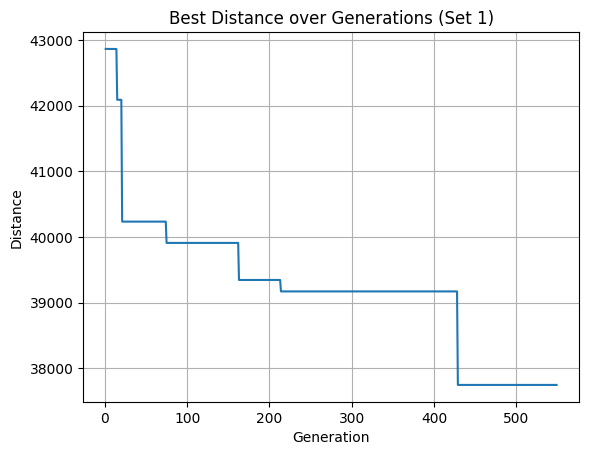

Running GA with parameter set 2: {'population_size': 100, 'crossover_rate': 0.6, 'mutation_rate': 0.08, 'selection_method': 'tournament', 'tournament_size': 4}
Generation 0: Best distance = 39710
Generation 1: Best distance = 39710
Generation 2: Best distance = 39710
Generation 3: Best distance = 39710
Generation 4: Best distance = 39710
Generation 5: Best distance = 39710
Generation 6: Best distance = 39710
Generation 7: Best distance = 39710
Generation 8: Best distance = 39710
Generation 9: Best distance = 39710
Generation 10: Best distance = 39710
Generation 11: Best distance = 39710
Generation 12: Best distance = 39710
Generation 13: Best distance = 39710
Generation 14: Best distance = 39710
Generation 15: Best distance = 39710
Generation 16: Best distance = 39710
Generation 17: Best distance = 39710
Generation 18: Best distance = 39710
Generation 19: Best distance = 39710
Generation 20: Best distance = 39710
Generation 21: Best distance = 39710
Generation 22: Best distance = 39710

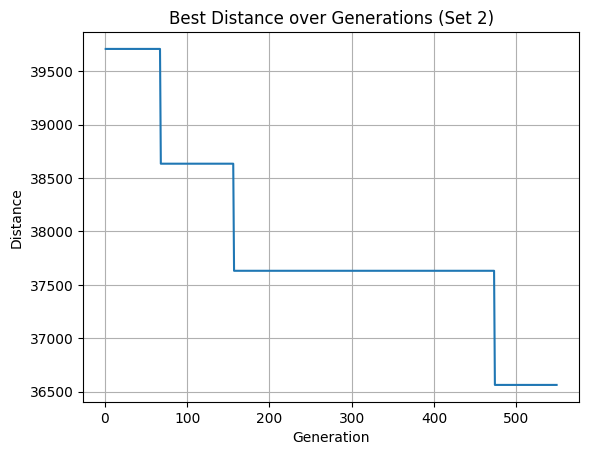

Running GA with parameter set 3: {'population_size': 150, 'crossover_rate': 0.5, 'mutation_rate': 0.1, 'selection_method': 'tournament', 'tournament_size': 2}
Generation 0: Best distance = 42554
Generation 1: Best distance = 42554
Generation 2: Best distance = 42554
Generation 3: Best distance = 42554
Generation 4: Best distance = 42554
Generation 5: Best distance = 42554
Generation 6: Best distance = 40037
Generation 7: Best distance = 40037
Generation 8: Best distance = 40037
Generation 9: Best distance = 40037
Generation 10: Best distance = 40037
Generation 11: Best distance = 40037
Generation 12: Best distance = 40037
Generation 13: Best distance = 40037
Generation 14: Best distance = 40037
Generation 15: Best distance = 40037
Generation 16: Best distance = 40037
Generation 17: Best distance = 40037
Generation 18: Best distance = 40037
Generation 19: Best distance = 40037
Generation 20: Best distance = 40037
Generation 21: Best distance = 40037
Generation 22: Best distance = 40037


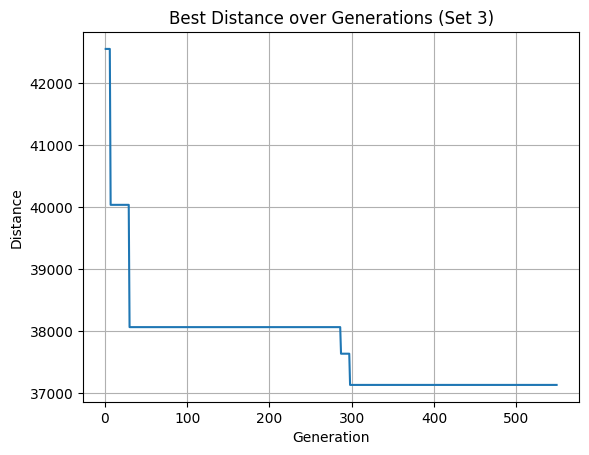

Running GA with parameter set 4: {'population_size': 75, 'crossover_rate': 0.8, 'mutation_rate': 0.05, 'selection_method': 'tournament', 'tournament_size': 5}
Generation 0: Best distance = 42756
Generation 1: Best distance = 42756
Generation 2: Best distance = 42756
Generation 3: Best distance = 42756
Generation 4: Best distance = 42756
Generation 5: Best distance = 42756
Generation 6: Best distance = 42756
Generation 7: Best distance = 42756
Generation 8: Best distance = 42756
Generation 9: Best distance = 42756
Generation 10: Best distance = 42756
Generation 11: Best distance = 42756
Generation 12: Best distance = 42756
Generation 13: Best distance = 42756
Generation 14: Best distance = 42756
Generation 15: Best distance = 42756
Generation 16: Best distance = 42756
Generation 17: Best distance = 42756
Generation 18: Best distance = 42756
Generation 19: Best distance = 42756
Generation 20: Best distance = 42756
Generation 21: Best distance = 42756
Generation 22: Best distance = 42756


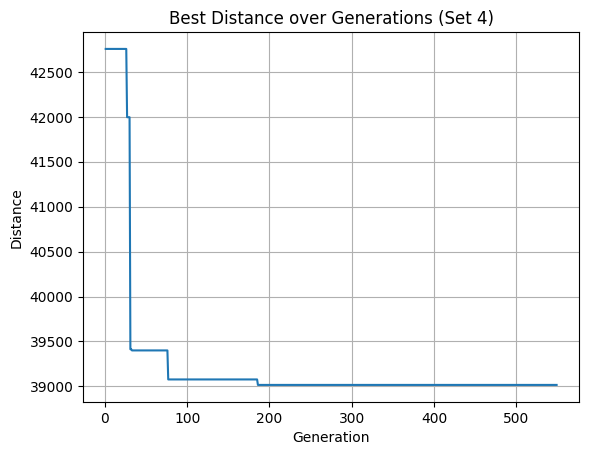

Running GA with parameter set 5: {'population_size': 125, 'crossover_rate': 0.7, 'mutation_rate': 0.03, 'selection_method': 'tournament', 'tournament_size': 3}
Generation 0: Best distance = 39752
Generation 1: Best distance = 39752
Generation 2: Best distance = 39752
Generation 3: Best distance = 39752
Generation 4: Best distance = 39752
Generation 5: Best distance = 39752
Generation 6: Best distance = 39752
Generation 7: Best distance = 39752
Generation 8: Best distance = 39752
Generation 9: Best distance = 39752
Generation 10: Best distance = 39752
Generation 11: Best distance = 39752
Generation 12: Best distance = 39752
Generation 13: Best distance = 39752
Generation 14: Best distance = 39752
Generation 15: Best distance = 39752
Generation 16: Best distance = 39752
Generation 17: Best distance = 39752
Generation 18: Best distance = 39752
Generation 19: Best distance = 39752
Generation 20: Best distance = 39752
Generation 21: Best distance = 39752
Generation 22: Best distance = 39752

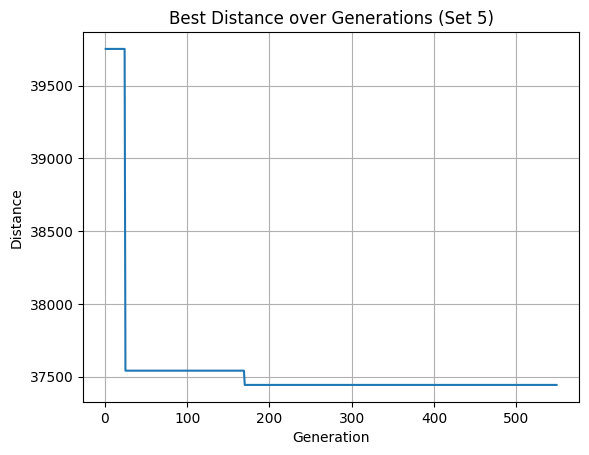

Running GA with parameter set 6: {'population_size': 100, 'crossover_rate': 0.9, 'mutation_rate': 0.02, 'selection_method': 'tournament', 'tournament_size': 6}
Generation 0: Best distance = 41377
Generation 1: Best distance = 39909
Generation 2: Best distance = 39909
Generation 3: Best distance = 39909
Generation 4: Best distance = 39909
Generation 5: Best distance = 39909
Generation 6: Best distance = 39909
Generation 7: Best distance = 39909
Generation 8: Best distance = 39909
Generation 9: Best distance = 39909
Generation 10: Best distance = 39909
Generation 11: Best distance = 39909
Generation 12: Best distance = 39909
Generation 13: Best distance = 39909
Generation 14: Best distance = 39909
Generation 15: Best distance = 38395
Generation 16: Best distance = 38395
Generation 17: Best distance = 38395
Generation 18: Best distance = 38395
Generation 19: Best distance = 38395
Generation 20: Best distance = 38395
Generation 21: Best distance = 38395
Generation 22: Best distance = 38395

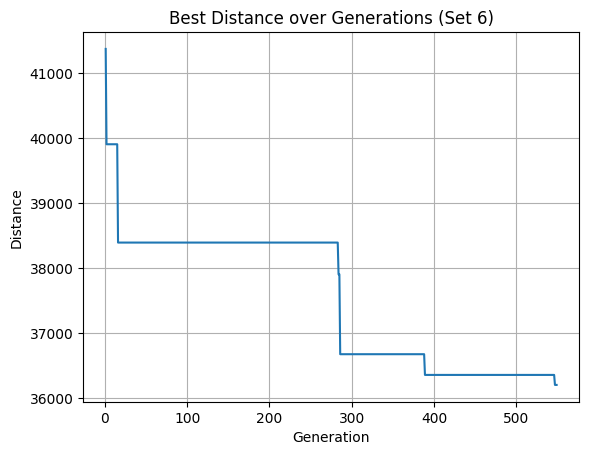

In [37]:
import matplotlib.pyplot as plt

for i, params in enumerate(parameter_sets):
    print(f"Running GA with parameter set {i + 1}: {params}")
    best_solution, best_distance, best_distances_per_generation = run_genetic_algorithm_with_params(problem, params)

    #plot the performance for this parameter set
    plt.figure()  # create a new figure for each parameter set
    plt.plot(best_distances_per_generation)
    plt.title(f'Best Distance over Generations (Set {i + 1})')
    plt.xlabel('Generation')
    plt.ylabel('Distance')
    plt.grid(True)
    plt.show()

### Parameter Tuning Analysis

Parameter Set 1: {'population_size': 50, 'crossover_rate': 0.7, 'mutation_rate': 0.01, 'selection_method': 'tournament', 'tournament_size': 3}
Best Distance: 36113

Parameter Set 2: {'population_size': 100, 'crossover_rate': 0.6, 'mutation_rate': 0.08, 'selection_method': 'tournament', 'tournament_size': 4}
Best Distance: 37780

Parameter Set 3: {'population_size': 150, 'crossover_rate': 0.5, 'mutation_rate': 0.1, 'selection_method': 'tournament', 'tournament_size': 2}
Best Distance: 36858

Parameter Set 4: {'population_size': 75, 'crossover_rate': 0.8, 'mutation_rate': 0.05, 'selection_method': 'tournament', 'tournament_size': 5}
Best Distance: 35305

Parameter Set 5: {'population_size': 125, 'crossover_rate': 0.7, 'mutation_rate': 0.03, 'selection_method': 'tournament', 'tournament_size': 3}
Best Distance: 35112

Parameter Set 6: {'population_size': 100, 'crossover_rate': 0.9, 'mutation_rate': 0.02, 'selection_method': 'tournament', 'tournament_size': 6}
Best Distance: 37148



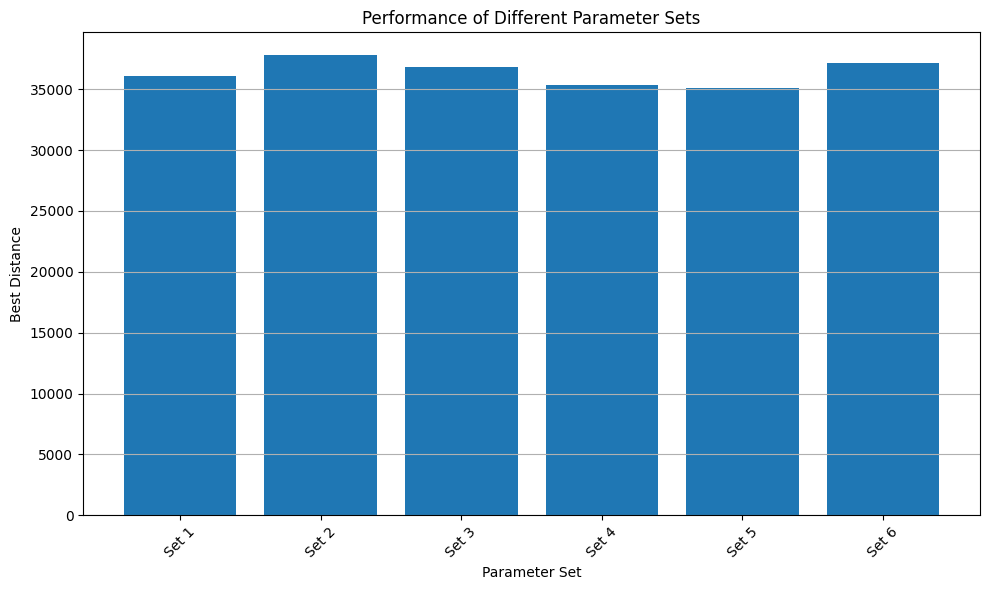

In [38]:
# Assuming 'results' contains tuples of (params, best_solution, best_distance)
for i, (params, _, best_distance) in enumerate(results):
    print(f"Parameter Set {i + 1}: {params}")
    print(f"Best Distance: {best_distance}\n")

# Prepare data for plotting
best_distances = [best_distance for _, _, best_distance in results]

# Plotting the performance of each parameter set
plt.figure(figsize=(10, 6))  # Optional: Adjust figure size as needed
plt.bar(range(len(results)), best_distances, tick_label=[f"Set {i+1}" for i in range(len(results))])
plt.title('Performance of Different Parameter Sets')
plt.xlabel('Parameter Set')
plt.ylabel('Best Distance')
plt.xticks(rotation=45)  # Optional: Rotate labels for readability
plt.grid(axis='y')  # Optional: Add a grid for the y-axis
plt.tight_layout()  # Adjust layout to fit everything nicely
plt.show()